In [1]:
from utils import train_utils, data_utils, anchor_utils, bbox_utils
import tensorflow as tf
from config import *
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL']= '2'

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as error:
        print(error)

1 Physical GPUs, 1 Logical GPUs


In [4]:
model, _, _, _ = train_utils.get_model()

Model: YOLOv4


In [5]:
dataloader = data_utils.DataLoader(batch_size=BATCH_SIZE)
test_dataset = dataloader('val', use_label=True)

/home/dblab/anaconda3/envs/tf28/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset: voc val
./data/voc/val.tfrecord is exist


In [6]:
data = next(iter(test_dataset))

In [7]:
images, s_grids, m_grids, l_grids, labels = data

In [8]:
def draw(image, p1, p2, color, width, box=True):
    if box:
        cv2.rectangle(image, p1,p2, color, width)
    else:
        c = ((p1 + p2)*0.5).astype(np.int32)
        cv2.circle(image, c, width, color, width)

[ 32. 288. 232. 169.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.]
[ 64. 288. 232. 169.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.]
3 5 2 4


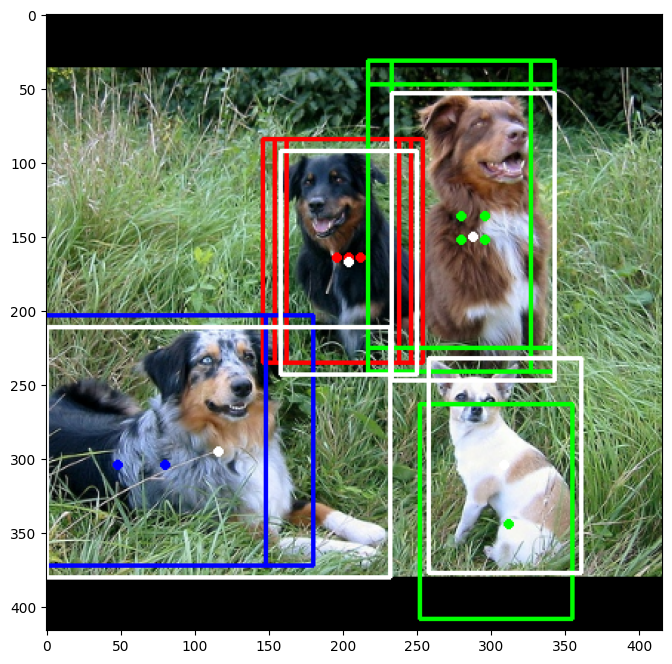

In [9]:
plt.figure(figsize=(8,8))
c_image = np.zeros((416,416,3), np.float32)
for i, (image, s_grid, m_grid, l_grid, label) in enumerate(zip(images.numpy()*255, s_grids, m_grids, l_grids, labels)):
    if i==0:
        image = image.astype(np.int32)

        ss = 0 
        for y, y_grid in enumerate(s_grid.numpy()):
            for x, x_grid in enumerate(y_grid):
                for a, grid in enumerate(x_grid):
                    if grid[4] != 0:
                        p1 = (grid[..., :2] - 0.5 * grid[..., 2:4]).astype(np.int32)
                        p2 = (grid[..., :2] + 0.5 * grid[..., 2:4]).astype(np.int32)
                        draw(image, p1, p2, (255, 0, 0), 2)
                        cv2.circle(image, (x*8+4, y*8+4), 2, (255, 0, 0), 2)
                        ss += 1
                        c_image[y*8+4, x*8+4] = (255., 0., 0.)
        
        mm = 0
        for y, y_grid in enumerate(m_grid.numpy()):
            for x, x_grid in enumerate(y_grid):
                for a, grid in enumerate(x_grid):
                    if grid[4] != 0:
                        p1 = (grid[..., :2] - 0.5 * grid[..., 2:4]).astype(np.int32)
                        p2 = (grid[..., :2] + 0.5 * grid[..., 2:4]).astype(np.int32)
                        draw(image, p1, p2, (0, 255, 0), 2)
                        cv2.circle(image, (x*16+8, y*16+8), 2, (0, 255, 0), 2)
                        mm += 1
                        c_image[y*16+8, x*16+8] = (0., 255., 0.)

        ll = 0
        for y, y_grid in enumerate(l_grid.numpy()):
            for x, x_grid in enumerate(y_grid):
                for a, grid in enumerate(x_grid):
                    if grid[4] != 0:
                        print(grid)
                        p1 = (grid[..., :2] - 0.5 * grid[..., 2:4]).astype(np.int32)
                        p2 = (grid[..., :2] + 0.5 * grid[..., 2:4]).astype(np.int32)
                        draw(image, p1, p2, (0, 0, 255), 2)
                        cv2.circle(image, (x*32+16, y*32+16), 2, (0, 0, 255), 2)
                        ll += 1
                        c_image[y*32+16, x*32+16] = (0., 0., 255.)

        gg = 0
        for g in label.numpy():
            if g[4] != 0:
                cv2.circle(image, g[..., :2].astype(np.int32), 2, (255, 255, 255), 2)
                p1 = (g[..., :2] - 0.5 * g[..., 2:4]).astype(np.int32)
                p2 = (g[..., :2] + 0.5 * g[..., 2:4]).astype(np.int32)
                draw(image, p1, p2, (255, 255, 255), 2)
                gg += 1
        plt.imshow(image)
        print(ss, mm, ll, gg)
        break
plt.show()

In [ ]:
iou 확인해보자 이상함

In [11]:
aa = np.array([320., 128., 335., 146])
bb = np.array([288. , 150. , 110. , 194])

In [12]:
bbox_utils.bbox_iou(aa, bb)

<tf.Tensor: shape=(), dtype=float64, numpy=0.3670773239468812>

In [28]:
335 * 146

48910

In [29]:
110*194

21340

In [30]:
21340/48910

0.43631159272132486

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


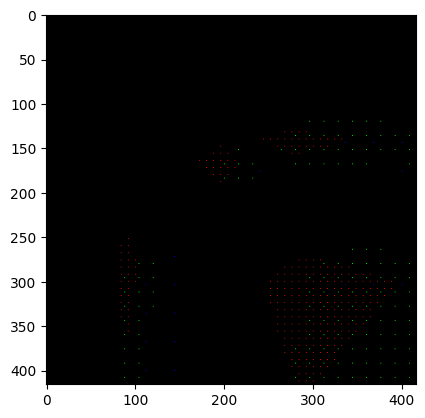

In [16]:
plt.imshow(c_image)
plt.show()

In [12]:
out = model(images[0:1])

In [13]:
len(out)

3

In [16]:
anchors = anchor_utils.get_anchors_xywh(ANCHORS, STRIDES, IMAGE_SIZE)

2


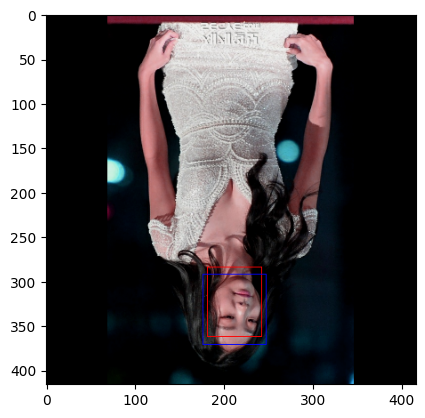

In [68]:
count = 0
i = (images[0].numpy()*255).astype(np.uint8)
for g, anchor, stride in zip(out, anchors, STRIDES):
    raw_bbox = g[..., :4]
    raw_conf = g[..., 4:5]
    raw_prob = g[..., 5:]
    pred_xy = tf.sigmoid(raw_bbox[..., :2]) + anchor[..., :2]
    pred_wh = tf.exp(raw_bbox[..., 2:4]) * anchor[..., 2:4]
    pred_bbox = tf.concat([pred_xy, pred_wh], -1) * stride
    pred_conf = tf.sigmoid(raw_conf)
    pred_prob = tf.argmax(tf.sigmoid(raw_prob), -1)[..., None]

    best_c = 0.
    best_box = [[0,0],[0,0]]

    for b, c, p in zip(pred_bbox.numpy().reshape(-1, 4), pred_conf.numpy().reshape(-1, 1), pred_prob.numpy().reshape(-1, 1)):
        
        if c>0.7:
            p1 = (b[:2] - 0.5 * b[2:4]).astype(np.int32)
            p2 = (b[:2] + 0.5 * b[2:4]).astype(np.int32)
            cv2.rectangle(i, p1, p2, (255, 0, 0), 1)
            count += 1
            if best_c < c:
                best_c = c
                best_box = [p1, p2]

    cv2.rectangle(i, best_box[0], best_box[1], (0, 0, 255), 1)
print(count)
plt.imshow(i)
plt.show()

[0.43461427]
[0.48018727]
[0.45176256]
[0.42994535]
4


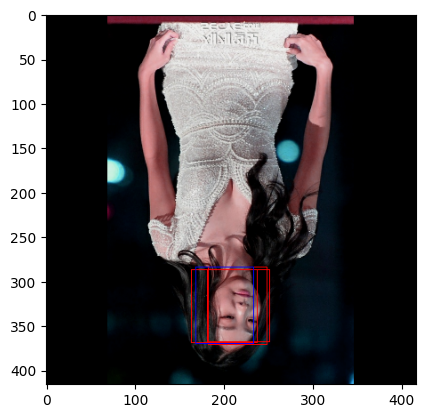

In [78]:
from utils import post_processing
anchors_flat = list(map(lambda x: tf.reshape(x, [-1,4]), anchor_utils.get_anchors_xywh(ANCHORS, STRIDES, IMAGE_SIZE)))

batch_processed_preds = post_processing.prediction_to_bbox(out, anchors_flat, 1, STRIDES, NUM_CLASSES, IMAGE_SIZE)
count = 0
best_cc = 0
best_bbox = [[0,0], [0,0]]
i = (images[0].numpy()*255).astype(np.uint8)

for pred in batch_processed_preds[0].numpy():
    bb = pred[..., :4]
    cc = pred[..., 4:5]
    pp = pred[..., 5:]

    pp1 = bb[..., :2].astype(np.int32)
    pp2 = bb[..., 2:4].astype(np.int32)
    if cc>0.4:
        print(cc)
        cv2.rectangle(i, pp1, pp2, (255, 0, 0), 1)
        count += 1
    if best_cc < cc:
        best_cc = cc
        best_bbox = [pp1, pp2]
cv2.rectangle(i, best_box[0], best_box[1], (0, 0, 255), 1)
print(count)
plt.imshow(i)
plt.show()

In [59]:
batch_processed_preds

<tf.Tensor: shape=(1, 10647, 6), dtype=float32, numpy=
array([[[0.0000000e+00, 0.0000000e+00, 1.4094934e+01, 2.4331924e+01,
         4.9108446e-02, 5.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 2.8412165e+01, 2.2950520e+01,
         3.8175445e-02, 2.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 5.2360771e+01, 4.0975948e+01,
         3.4180187e-02, 2.0000000e+00],
        ...,
        [3.4984497e+02, 3.0781497e+02, 4.1600000e+02, 4.1600000e+02,
         2.6371736e-02, 4.0000000e+00],
        [3.3699387e+02, 3.3952225e+02, 4.1600000e+02, 4.1600000e+02,
         2.0297943e-02, 4.0000000e+00],
        [3.1097723e+02, 2.3687576e+02, 4.1600000e+02, 4.1600000e+02,
         2.4659639e-02, 4.0000000e+00]]], dtype=float32)>

In [23]:
import numpy as np
from config import *

def bbox_iou(bbox1, bbox2, xywh=True, iou_type='iou', eps=EPS, inf=INF, image_size=IMAGE_SIZE):
    if xywh:
        bbox1 = np.concatenate([bbox1[..., :2] - bbox1[..., 2:] * 0.5, bbox1[..., :2] + bbox1[..., 2:] * 0.5], -1)
        bbox2 = np.concatenate([bbox2[..., :2] - bbox2[..., 2:] * 0.5, bbox2[..., :2] + bbox2[..., 2:] * 0.5], -1)
    bbox1 = np.minimum(np.maximum(bbox1, 0.0), image_size)
    bbox2 = np.minimum(np.maximum(bbox2, 0.0), image_size)
    area1 = np.prod(bbox1[..., 2:] - bbox1[..., :2], -1)
    area2 = np.prod(bbox2[..., 2:] - bbox2[..., :2], -1)

    Left_Top = np.maximum(bbox1[..., :2], bbox2[..., :2])
    Right_Bottom = np.minimum(bbox1[..., 2:], bbox2[..., 2:])

    inter_section = np.maximum(Right_Bottom - Left_Top, 0.0)
    inter_area = np.prod(inter_section, -1)
    union_area = np.maximum(area1 + area2 - inter_area, eps)

    iou = inter_area / union_area

    if iou_type in ['giou', 'diou', 'ciou']:
        c_Left_Top = np.minimum(bbox1[..., :2], bbox2[..., :2])
        c_Right_Bottom = np.maximum(bbox1[..., 2:], bbox2[..., 2:])
        if iou_type == 'giou':
            c_area = np.maximum(np.prod(c_Right_Bottom - c_Left_Top, -1), eps)
            giou = iou - (c_area - union_area)/c_area
            return giou
        
        elif iou_type in ['diou', 'ciou']:
            center_xy1 = (bbox1[..., :2] + bbox1[..., 2:]) * 0.5
            center_xy2 = (bbox2[..., :2] + bbox2[..., 2:]) * 0.5
            p_square = np.sum(np.minimum((center_xy1 - center_xy2)**2, inf), -1)
            c_square = np.sum(np.minimum(np.maximum(np.square(c_Right_Bottom - c_Left_Top), eps), inf), -1)

            if iou_type == 'diou':
                diou = iou - p_square/c_square
                return diou
            
            w1 = bbox1[..., 2] - bbox1[..., 0]
            h1 = np.maximum(bbox1[..., 3] - bbox1[..., 1], eps)
            w2 = bbox2[..., 2] - bbox2[..., 0]
            h2 = np.maximum(bbox2[..., 3] - bbox2[..., 1], eps)

            v = 4/np.pi**2 * (np.arctan(w1/h1) - np.arctan(w2/h2))**2
            alpha = v/np.maximum((1.0 - iou + v), eps)
            ciou = iou - p_square/c_square - alpha*v
            return ciou
    return iou

In [24]:
gt = np.array([[100, 100, 300, 200]], np.float32)
pr = np.array([[x, x, 500, 500] for x in range(-1000, 1000, 100)], np.float32)

In [25]:
iou = bbox_iou(gt, pr, iou_type='ciou')

In [26]:
1-iou

array([1.3298932 , 1.3298932 , 1.3298932 , 1.3298932 , 1.3298932 ,
       1.3298932 , 1.3298932 , 1.3298932 , 1.1024648 , 0.5805322 ,
       0.20512015, 0.62504125, 0.7647146 , 0.88997734, 1.125716  ,
       1.2818784 , 1.4237399 , 1.6130645 , 1.6130645 , 1.6130645 ],
      dtype=float32)

In [21]:
1-iou

array([1.5562478 , 1.5289963 , 1.4983239 , 1.463594  , 1.4240294 ,
       1.3786949 , 1.3265097 , 1.2663578 , 1.1811163 , 1.0138863 ,
       0.80032146, 0.7603215 , 0.80032146, 1.0138863 , 1.1811163 ,
       1.2663578 , 1.3265097 , 1.3786949 , 1.4240294 , 1.463594  ],
      dtype=float32)

In [133]:
coord_scale = 2.0 - 1.0 * tf.reduce_prod(pr[..., 2:4]/400, -1, keepdims=True)

In [113]:
coord_scale

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[1.9375],
       [1.9375],
       [1.9375],
       [1.9375],
       [1.9375],
       [1.9375],
       [1.9375],
       [1.9375],
       [1.9375],
       [1.9375]], dtype=float32)>

In [ ]:
triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to
이거 에러 잡기

In [19]:
tf.exp(-0.5)

<tf.Tensor: shape=(), dtype=float32, numpy=0.60653067>